<a href="https://colab.research.google.com/github/mgomezo12/GWL_ML_Basis/blob/main/DRAFT_ML_IntroWorkshop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#import os
#os.kill(os.getpid(), 9)

This notebook takes some examples and guidelines from the tensorflow tutorial that you can find here: https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/structured_data/time_series.ipynb#scrollTo=qoFJZmXBaxCc

The adaptations made are in order to serve as examples for an introductory workshop on groundwater level forecasting using deep learning

In [ ]:
import os
import datetime
import pandas as pd

from google.colab import drive
drive.mount('/content/drive')


import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
tf.random.set_seed(1)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Flatten
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score

from sklearn.preprocessing import MinMaxScaler



Mounted at /content/drive


# Machine learning workflow - Introduction to groundwater time series data

## Gathering input data



*   Data accessibility
*   Licensing
*   Data format

Besides groundwater data additional information to feed the model is required such as metereological information



### Setup the dataset

Two datasets:
- Groundwater level time series
- Meteorological data

The dataset is in weekly resolution

In [ ]:
#Load dataset
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/gseu_t41_dataset/mldataset_t1_mod.csv')
date_time = pd.to_datetime(df.pop('date'), format='%Y-%m-%d')

In [ ]:
df.head()

,gwl,pr,tm
0,3.20,11.023824,16.794464
1,3.19,0.800202,14.949683
2,3.22,0.000000,15.276594
3,3.20,0.000000,18.337181
4,3.16,0.047861,15.560719


## Exploratory data analysis (EDA)

Plot the data

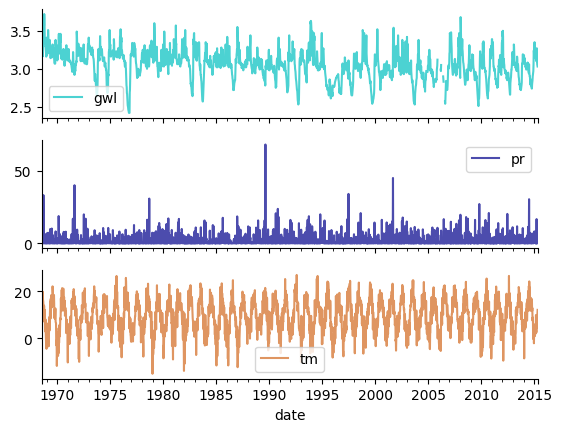

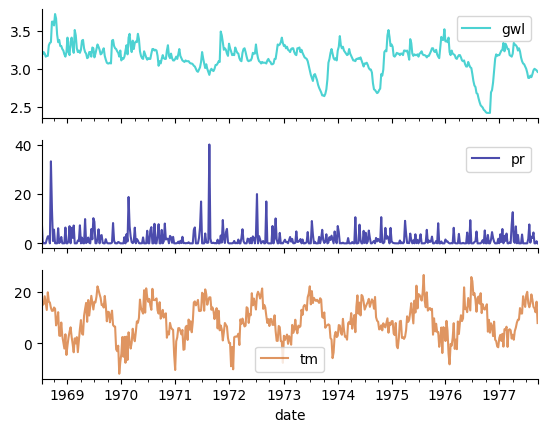

In [ ]:
# Your code to create the initial subplots
plot_cols = ['gwl', 'pr', 'tm']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True, color=['c', 'darkblue', 'chocolate'], alpha=0.7)
plt.rcParams['axes.edgecolor'] = 'black'
# Iterate through each subplot to remove upper and right frames
for ax in plt.gcf().get_axes():
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_color('black')
    ax.spines['left'].set_color('black')

# Your code to create the second set of subplots
plot_features = df[plot_cols][:480]
plot_features.index = date_time[:480]
_ = plot_features.plot(subplots=True, color=['c', 'darkblue', 'chocolate'], alpha=0.7)

# Iterate through each subplot to remove upper and right frames and set their color to black
for ax in plt.gcf().get_axes():
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_color('black')
    ax.spines['left'].set_color('black')

### Inspect and cleanup

We see it as all the main statistics have a coherent value. This is important to verify how reasonable is our data.

In [ ]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
gwl,2401.0,3.052840,0.192950,2.420000,2.950000,3.060000,3.170000,3.720000
pr,2443.0,2.076683,4.047708,0.000000,0.000000,0.275347,2.607374,68.213520
tm,2443.0,9.192761,6.971981,-15.286106,4.264971,9.334988,14.628861,27.092731


### Fill NaN

Machine learning algorithms in tensorflow do not receive datasets with missing values (NaN), so first we should appropiately fill the values. To create a smooth interpolation, we perform a PCHIP (Piecewise Cubic Hermite Interpolating Polynomial).

In [ ]:
#Check for the missing values inside the dataset
nandf=df[df.gwl.isna()]
len(nandf)

42

In [ ]:
dfc=df.copy()
dfc=dfc.set_index(date_time)
dfin=dfc.interpolate('pchip', order=2) #linear

Remember to review the dataset after the interpolation.  

Text(0, 0.5, 'GWL levels')

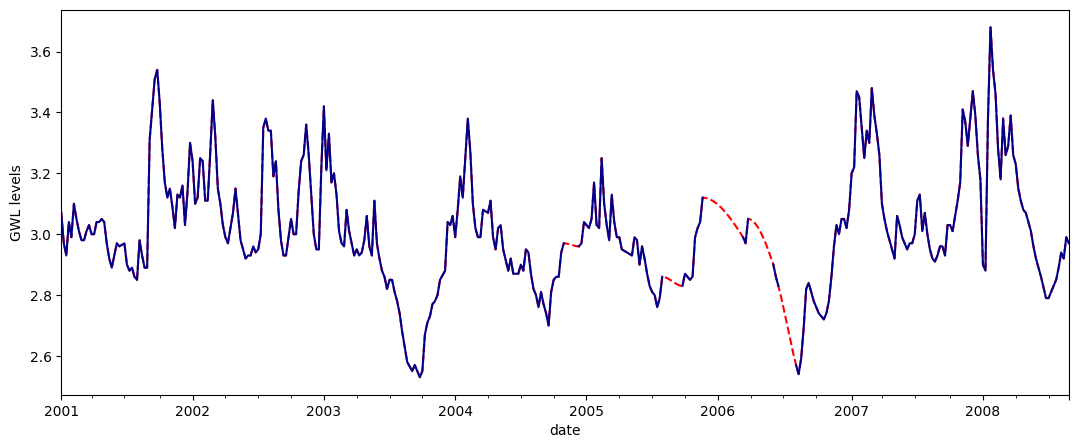

In [ ]:

plt.figure(figsize=(13, 5))
inc=200
dfin[nandf.index[0]-inc:nandf.index[0]+inc].gwl.plot(color='red', label='Interpolate value', linestyle='dashed')
dfc[nandf.index[0]-inc:nandf.index[0]+inc].gwl.plot(color='darkblue', label='Observed')
plt.ylabel('GWL levels')

In [ ]:
df=df.interpolate('pchip', order=2)

###Time

Weather data has clear daily and yearly periodicity. As we are working with a weekly time resolution, we care for the yearly resolution

Compute the <a href="https://en.wikipedia.org/wiki/Fast_Fourier_transform" class="external">Fast Fourier Transform</a>. Here is the `tf.signal.rfft` of the temperature over time. Note the obvious peak at frequencies near `1/year`

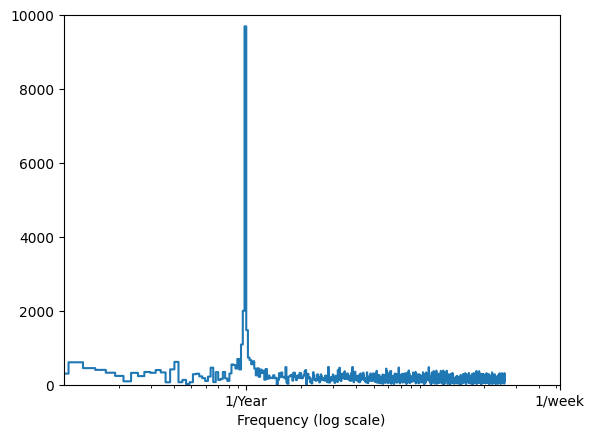

In [ ]:
fft = tf.signal.rfft(df['tm'])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(df['tm'])
hours_per_year = 52
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 10000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 52], labels=['1/Year', '1/week'])
_ = plt.xlabel('Frequency (log scale)')

In [ ]:
year = 52 #Number of weeks on a year
df['Tyrsin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Tyrcos'] = np.cos(timestamp_s * (2 * np.pi / year))


Text(0.5, 1.0, 'Time of year signal')

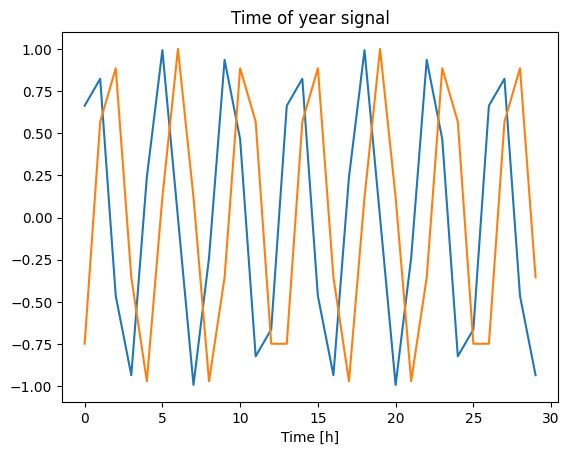

In [ ]:
plt.plot(np.array(df['Tyrsin'])[:30])
plt.plot(np.array(df['Tyrcos'])[:30])
plt.xlabel('Time [h]')
plt.title('Time of year signal')

### Normalize the data
It is important to scale features before training a neural network. Normalization is a common way of doing this scaling: subtract the mean and divide by the standard deviation of each feature. In particular, due to GWL time series variation, it is consider benficial to scale the values between -1 and 1.  Normalizing the data helps to ensure that the CNN is not biased.

In [ ]:
#scale data
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler_gwl = MinMaxScaler(feature_range=(-1, 1))
scaler_gwl.fit(pd.DataFrame(df['gwl']))
df_n = pd.DataFrame(scaler.fit_transform(df), index=df.index, columns=df.columns)

## Split the data

We'll use a (80%, 10%, 10%) split for the training, validation, and test sets. Note the data is not being randomly shuffled before splitting. This is for two reasons:

It ensures that chopping the data into windows of consecutive samples is still possible.
It ensures that the validation/test results are more realistic, being evaluated on the data collected after the model was trained.

In [ ]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_dfn = df_n[0:int(n*0.8)]
val_dfn = df_n[int(n*0.8):int(n*0.9)]
test_dfn = df_n[int(n*0.9):]
dates_test=date_time[int(n*0.9):]

## Model Selection

## Sequential data (windowing)

The GWL time series data is input into the model as smaller sequences or "windows". Each subsequence capture a segment of the time series and therefore, the patterns inside these segments that the model will learn during the training. Here, we should define the sequence length (`sl`), which is an hyperparameter.

Depending on the task and type of model you may want to generate a variety of data windows. For instance,  a single prediction a week into the future, given 6 weeks of history look like:

  ![One prediction one hour into the future.](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/raw_window_1h.png?raw=1)

In [ ]:
def seq_length(df, features, target, sequence_length):

  f_df=df[features]
  t_df=df[target]

  Xn, yn = [], []

  for i in range(len(f_df) - sequence_length):
      Xn.append(f_df[i : i + sequence_length])
      yn.append(t_df.iloc[i + sequence_length])

  Xn, yn = np.array(Xn), np.array(yn)

  return Xn, yn


f=['gwl','pr', 'tm','Tyrsin']
t=['gwl']

sl=10 #Sequence length
Xn_train, yn_train= seq_length(train_dfn, features=f, target=t, sequence_length=sl)
Xn_val, yn_val= seq_length(val_dfn, features=f, target=t, sequence_length=sl)
Xn_test, yn_test= seq_length(test_dfn, features=f, target=t, sequence_length=sl)



## CNN model

First, let's build a 1D Convolutional Neural Network (CNN).
A convolution layer (`tf.keras.layers.Conv1D`) takes multiple time steps as input to each prediction. The network parameters to be tuned are:


*   `filters` : number of windows moving across the input data to detect features. (usually selected as a power of 2 e.g. 32, 64, 128).
*   `kernel_size`: define the size of the filters, usuarlly 3. Small kernel sizes capture better patterns and details in the input data.
*   `activation` : the activation function applied after convolution ('RELU' stands for rectified linear unit and it is the most popular activation function)
*    `units`: The number of neurons in the layer.
*   `padding` : set to 'same' means the model output size is the same as the input

The (`seed`) allow to ensure reproducibility, meaning that every time we run the code we obtain the same results. This value is arbitrary and usually an integer.



In [ ]:
ini=1

tf.random.set_seed(ini+500)

# Define your CNN model
model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(sl, df[f].shape[1]), padding='same'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1, activation='linear')
])

On the model compilation we should define the following:

*   `optimizer`: The choice of optimizer (e.g., 'adam', 'sgd', etc.). Adam optimization algorithm is the most used one and states for Adaptive Moment Estimation. Ajust the weights of the neural network to minimize the loss function.
*   `loss`: The loss function used during training. Here Mean Squared Error `mse` is used as it is common on regression tasks.
*   `metrics`: define which metric to track during training.

In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mse'])

# Print the model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 10, 32)            416       
                                                                 
 flatten_1 (Flatten)         (None, 320)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                20544     
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 21025 (82.13 KB)
Trainable params: 21025 (82.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


The model summary shows the model architecture we have built.


1.   **conv1d layer** : 3D tensor  (batch_size, sequence_length, number_of_filters) with 416 parameters (weights + bias)
2.   **fatten layer** : Flattens the 3D tensor into a 1D tensor.
3.   **Dense layer 1** : fully connected layer with the number of units (previously defined) as shapes.
4.   **Dense layer 2** : fully connected layer with the final output shape.



For **training the model** we define the number of `epochs` (in each epoch the model is trained through the entire dataset, updating the weights and biases). An adequate number of epochs creates a balance between overfitting and underfitting.

Here we add a regularization technique known as early stopping which help preventing overfitting. The main idea is to stop the training once the performance stops improving. The `patience` states for the number of epochs with no improvement after which training will be stopped.


In [ ]:
# Train the model
epochs = 20
# early stopping
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=15, restore_best_weights = True)

history = model.fit(Xn_train, yn_train, epochs=epochs, validation_data=(Xn_val, yn_val), batch_size=32, verbose=1, callbacks=[es])

Epoch 1/20
61/61 [==============================] - 2s 9ms/step - loss: 0.0333 - mse: 0.0333 - val_loss: 0.0264 - val_mse: 0.0264
Epoch 2/20
61/61 [==============================] - 0s 6ms/step - loss: 0.0182 - mse: 0.0182 - val_loss: 0.0208 - val_mse: 0.0208
Epoch 3/20
61/61 [==============================] - 0s 5ms/step - loss: 0.0164 - mse: 0.0164 - val_loss: 0.0215 - val_mse: 0.0215
Epoch 4/20
61/61 [==============================] - 0s 6ms/step - loss: 0.0147 - mse: 0.0147 - val_loss: 0.0191 - val_mse: 0.0191
Epoch 5/20
61/61 [==============================] - 0s 5ms/step - loss: 0.0131 - mse: 0.0131 - val_loss: 0.0164 - val_mse: 0.0164
Epoch 6/20
61/61 [==============================] - 0s 5ms/step - loss: 0.0130 - mse: 0.0130 - val_loss: 0.0153 - val_mse: 0.0153
Epoch 7/20
61/61 [==============================] - 0s 5ms/step - loss: 0.0117 - mse: 0.0117 - val_loss: 0.0153 - val_mse: 0.0153
Epoch 8/20
61/61 [==============================] - 0s 7ms/step - loss: 0.0113 - mse: 0.01

### Model evaluation

In [ ]:
# Evaluate the model on the validation set
val_loss, val_mae = model.evaluate(Xn_val, yn_val)
print(f'Validation Loss: {val_loss:.4f}, Validation MAE: {val_mae:.4f}')

# Evaluate the model on the test set
test_loss, test_mae = model.evaluate(Xn_test, yn_test)
print(f'Test Loss: {test_loss:.4f}, Test MAE: {test_mae:.4f}')

# Make predictions on the validation and test sets
yn_val_pred = model.predict(Xn_val)
yn_test_pred = model.predict(Xn_test)

# Calculate R² for validation set
r2_val = r2_score(yn_val, yn_val_pred)
print(f'Validation R²: {r2_val:.4f}')

# Calculate R² for test set
r2_test = r2_score(yn_test, yn_test_pred)
print(f'Test R²: {r2_test:.4f}')

# Calculate NSE for test set
err=yn_test_pred- np.mean(np.asarray(yn_train))
nse_test = 1 - np.sum((yn_test - yn_test_pred)**2) / np.sum((err)**2)
print(f'Test NSE: {nse_test:.4f}')

8/8 [==============================] - 0s 3ms/step - loss: 0.0149 - mse: 0.0149
Validation Loss: 0.0149, Validation MAE: 0.0149
8/8 [==============================] - 0s 4ms/step - loss: 0.0124 - mse: 0.0124
Test Loss: 0.0124, Test MAE: 0.0124
8/8 [==============================] - 0s 5ms/step
Validation R²: 0.8619
Test R²: 0.8161
Test NSE: 0.8312


### Plot the results

First we should inverse the normalization to plot the actual groundwater level values.

In [ ]:
y_test_pred = scaler_gwl.inverse_transform(yn_test_pred)
y_test = scaler_gwl.inverse_transform(yn_test)

#Dates of the test set
dates_testv=dates_test[:len(dates_test)-sl].values

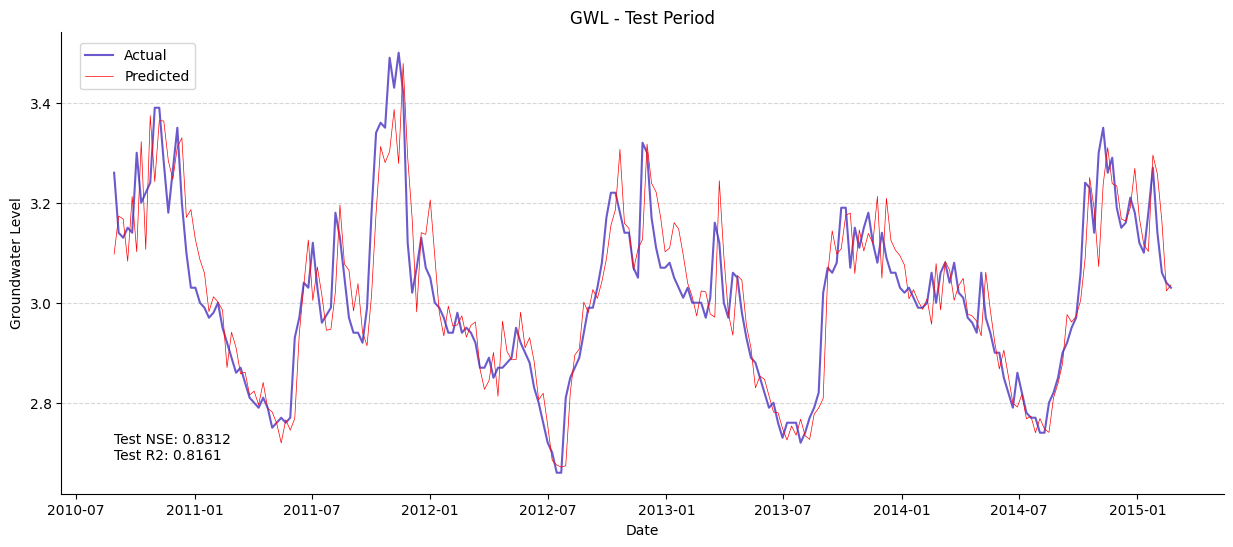

In [ ]:
plt.figure(figsize=(15, 6))

z = 1000  # zoom

# Plot the actual values during the test period
plt.plot(dates_testv[:z], y_test[:z], label='Actual', color='slateblue')

# Plot the predicted values during the test period
plt.plot(dates_testv[:z], y_test_pred[:z], label='Predicted', color='red', linestyle='-', linewidth=0.5)

# Display performance measures on the plot
plt.text(dates_testv[0], 1.01 * np.min(y_test), f'Test NSE: {nse_test:.4f}\nTest R2: {r2_test:.4f}', color='black')

# Set legend inside the plot
legend = plt.legend(loc='upper left', bbox_to_anchor=(0.01, 0.99))

# Remove the right and upper frame
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

# Add horizontal grids with high opacity
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.title('GWL - Test Period - CNN')
plt.xlabel('Date')
plt.ylabel('Groundwater Level')
plt.show()

## Long-Short-Term Memory (LSTM) network

In [ ]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(units=32, activation='tanh', recurrent_activation='sigmoid',
                         dropout=0.2 , recurrent_dropout=0.005,
                         kernel_initializer='zeros', bias_initializer='zeros',  input_shape=(sl, df[f].shape[1])),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

# Build the model
batch_size=32
lstm_model.build(input_shape=(batch_size, sl, df[f].shape[1]))

# Compile the model
lstm_model.compile(optimizer='adam', loss='mse', metrics=['mse'])

# Print the model summary
lstm_model.summary()

# Train the model
epochs = 50  ###

# early stopping
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=15, restore_best_weights = True)

history = lstm_model.fit(Xn_train, yn_train, epochs=epochs, validation_data=(Xn_val, yn_val), batch_size=32, verbose=0, callbacks=[es])

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 32)                4736      
                                                                 
 dense_6 (Dense)             (None, 1)                 33        
                                                                 
Total params: 4769 (18.63 KB)
Trainable params: 4769 (18.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Make predictions on the validation and test sets
yn_val_pred = lstm_model.predict(Xn_val)
yn_test_pred = lstm_model.predict(Xn_test)

8/8 [==============================] - 0s 7ms/step


In [ ]:
# Evaluate the model on the validation set
val_loss, val_mae = lstm_model.evaluate(Xn_val, yn_val)
print(f'Validation Loss: {val_loss:.4f}, Validation MAE: {val_mae:.4f}')

# Evaluate the model on the test set
test_loss, test_mae = lstm_model.evaluate(Xn_test, yn_test)
print(f'Test Loss: {test_loss:.4f}, Test MAE: {test_mae:.4f}')

# Calculate R² for validation set
r2_val = r2_score(yn_val, yn_val_pred)
print(f'Validation R²: {r2_val:.4f}')

# Calculate R² for test set
r2_test = r2_score(yn_test, yn_test_pred)
print(f'Test R²: {r2_test:.4f}')

# Calculate NSE for test set
err=yn_test_pred- np.mean(np.asarray(yn_train))
nse_test = 1 - np.sum((yn_test - yn_test_pred)**2) / np.sum((err)**2)
print(f'Test NSE: {nse_test:.4f}')

8/8 [==============================] - 0s 6ms/step - loss: 0.0153 - mse: 0.0153
Validation Loss: 0.0153, Validation MAE: 0.0153
8/8 [==============================] - 0s 6ms/step - loss: 0.0106 - mse: 0.0106
Test Loss: 0.0106, Test MAE: 0.0106
Validation R²: 0.8575
Test R²: 0.8433
Test NSE: 0.8259


In [ ]:
y_test_pred = scaler_gwl.inverse_transform(yn_test_pred)
y_test = scaler_gwl.inverse_transform(yn_test)

In [ ]:
#Dates of the test set
dates_testv=dates_test[:len(dates_test)-sl].values

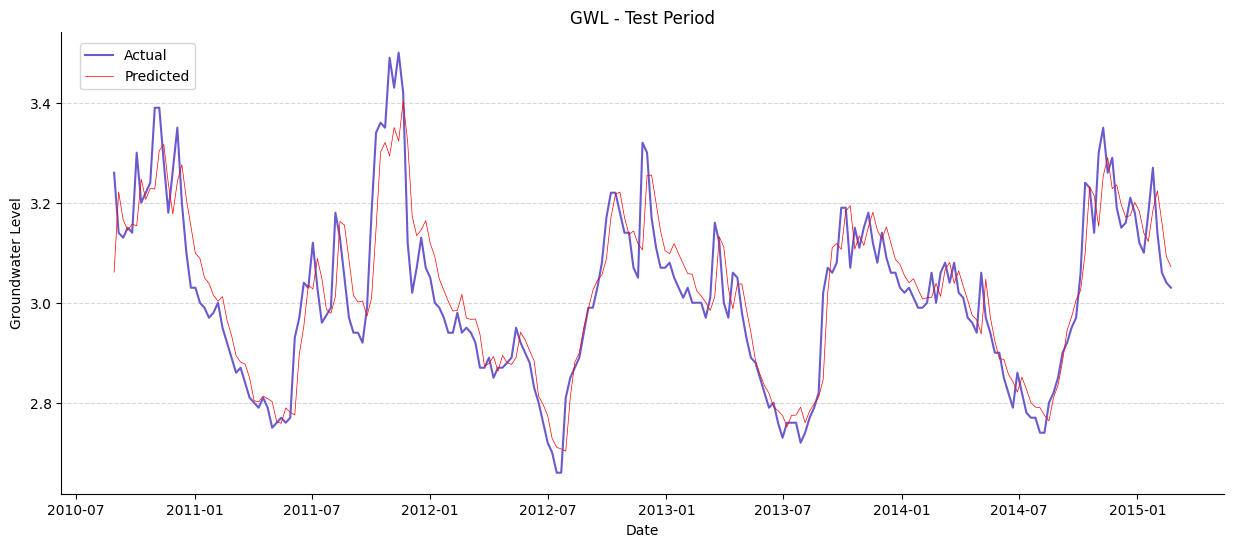

In [ ]:
plt.figure(figsize=(15, 6))

# Plot the actual values during the test period
plt.plot( dates_testv, y_test , label='Actual', color='slateblue')

# Plot the predicted values during the test period
plt.plot( dates_testv,  y_test_pred, label='Predicted', color='red', linestyle='-', linewidth=0.5)

# Display performance measures on the plot
#plt.text(dates_testv[0], 1.01 * np.min(y_test), f'Test NSE: {nse_test:.4f}\nTest R2: {r2_test:.4f}', color='black')

# Set legend inside the plot
legend = plt.legend(loc='upper left', bbox_to_anchor=(0.01, 0.99))

# Remove the right and upper frame
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

# Add horizontal grids with high opacity
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.title('GWL - Test Period- LSTM')
plt.xlabel('Date')
plt.ylabel('Groundwater Level')
plt.show()